In [37]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [38]:
import importlib
import genapon
import genapon.ffn as ffn
importlib.reload(ffn)
importlib.reload(genapon)
importlib.reload(genapon.deepsets_model)
from genapon import trainer
importlib.reload(trainer)
from genapon.trainer import Trainer
from tqdm import tqdm
from genapon import dataloader
from genapon import model
importlib.reload(dataloader)
importlib.reload(model)
from genapon.dataloader import UserViewsDataset
from genapon.model import GENAPON
import pandas as pd
import numpy as np
import seaborn as sns

In [39]:
from typing import Dict, Any

In [ ]:
path = r'/home/kyudin/jmlc/data/'
data = pd.read_csv(path + 'auth_users_gender_events.csv')
sex_labels = pd.read_csv(path + 'auth_sex_labels.csv')
user_features = pd.read_csv(path + "user_features.csv")

In [5]:
sex_labels['target'] = sex_labels['sex'].map({'male' : 0, 'female' : 1})
sex_labels = sex_labels.set_index('viewer_id')

In [6]:
data['event_date'] = pd.to_datetime(data['event_date'])
data['ua_os'].fillna('', inplace=True)

In [7]:
video_vc = data['video_id'].value_counts()
min_15_views = video_vc[video_vc >= 15].index
data = data[data['video_id'].isin(min_15_views)]
user_vc = data['viewer_id'].value_counts()

In [8]:
data = data[data['viewer_id'].isin(user_vc[user_vc >= 5].index)]

In [9]:
data['week'] = \
pd.cut(
    x=data['event_date'],
    bins=[pd.to_datetime(dt) for dt in['2025-05-25', '2025-06-01', '2025-06-08', '2025-06-15']],
    labels=[0, 1, 2]
)

In [10]:
data['day_of_month'] = data['event_date'].dt.day
unique_dow = data["day_of_week"].unique()
dow2token = {os: idx for idx, os in enumerate(unique_dow)}
data["day_of_week"] = data["day_of_week"].map(dow2token)

In [11]:
time_events_cols = ['day_of_week', 'local_hour', 'week', 'day_of_month']
data.loc[:, time_events_cols] = data.loc[:, time_events_cols].astype(np.float64)

In [12]:
def train_val_test_split(
    labels: pd.DataFrame,
    train_size: float,
    val_size: float
):
    """
    Args:
        labels (pd.DataFrame): Authorized users age/sex DataFrame
        train_size (float): train size
        val_size (float): validation size 

    Returns:
        Train/Val/Test DataFrames with labels
    """

    assert labels["viewer_id"].nunique() == len(labels), "..."

    unique_users = labels['viewer_id'].to_numpy().copy()
    np.random.shuffle(unique_users)

    n_users = len(unique_users)
    n_train = int(n_users * train_size)
    n_val = int(n_users * val_size)


    train_users = unique_users[:n_train]
    val_users = unique_users[n_train:n_train + n_val]
    test_users = unique_users[n_train + n_val:]

    train_labels = labels[labels["viewer_id"].isin(train_users)].copy()
    val_labels = labels[labels["viewer_id"].isin(val_users)].copy()
    test_labels = labels[labels["viewer_id"].isin(test_users)].copy()

    return train_labels, val_labels, test_labels

In [13]:
train_labels, val_labels, test_labels = train_val_test_split(sex_labels.reset_index(), train_size=0.7, val_size=0.1)

In [14]:
train_events = data[data['viewer_id'].isin(train_labels['viewer_id'])].copy()
val_events = data[data['viewer_id'].isin(val_labels['viewer_id'])].copy()
test_events = data[data['viewer_id'].isin(test_labels['viewer_id'])].copy()

In [15]:
train_user_features = user_features[user_features['viewer_id'].isin(train_labels['viewer_id'])].copy()
val_user_features = user_features[user_features['viewer_id'].isin(val_labels['viewer_id'])].copy()
test_user_features = user_features[user_features['viewer_id'].isin(test_labels['viewer_id'])].copy()

In [16]:
unique_videos = train_events['video_id'].unique()
video2token = {video: idx for idx, video in enumerate(unique_videos)}

train_events["video_id"] = train_events["video_id"].map(video2token)
val_events["video_id"] = val_events["video_id"].map(video2token)
test_events["video_id"] = test_events["video_id"].map(video2token)

In [17]:
val_events['video_id'].isna().sum() / len(val_events), test_events['video_id'].isna().sum() / len(test_events)

(0.00010400506157966355, 0.00014124027796086702)

In [18]:
UNK_TOKEN = train_events['video_id'].nunique()
val_events['video_id'] = val_events['video_id'].fillna(UNK_TOKEN).astype(int)
test_events['video_id'] = test_events['video_id'].fillna(UNK_TOKEN).astype(int)

In [19]:
train_labels = train_labels.set_index('viewer_id')
val_labels = val_labels.set_index('viewer_id')
test_labels = test_labels.set_index('viewer_id')


train_user_features = train_user_features.set_index('viewer_id')
val_user_features = val_user_features.set_index('viewer_id')
test_user_features = test_user_features.set_index('viewer_id')

In [40]:
train_dataset = UserViewsDataset(train_events, train_labels['target'], train_user_features)
val_dataset = UserViewsDataset(val_events, val_labels['target'], val_user_features)
test_dataset = UserViewsDataset(test_events, test_labels['target'], test_user_features)


BATCH_SIZE = 2048 * 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=test_dataset.collate_fn)

In [41]:
TIME_VECTOR_SIZE = 16
VIDEO_VECTOR_SIZE = 128
DEVICE = "cuda"

ModelConfig = {
    "device" : DEVICE,
    "v_num_embeddings" : train_events['video_id'].nunique() + 1,
    "v_embedding_dim" : VIDEO_VECTOR_SIZE,
    
   # LSTM Time2Vec layer
    "time_vector_input_size" : TIME_VECTOR_SIZE,
    "time_vector_hidden_size" : 16,


    # DeepSets Video FFN layer
    "v_hidden_dim" : 512,
    "v_output_dim" : 256,

    # LSTM(Time2Vec) FFN layer
    "t_hidden_dim" : 32,
    "t_output_dim" : 32,

    # User Features FFN layer
    "user_features_dim" : train_user_features.shape[1],
    "u_hidden_dim" : train_user_features.shape[1],
    "u_output_dim" : train_user_features.shape[1],

    # Classification FFN layer
    "c_hidden_dim" : 256,
    "c_output_dim" : 1
    
}

RhoConfig = {
    "out_features" : 256,
    "in_features" : 128,
}

PhiConfig = {
    "emb_dim" : VIDEO_VECTOR_SIZE,
    "out_features" : 128
}

T2vConfig = {
    "in_features" : 4,
    "emb_dim" : TIME_VECTOR_SIZE
}

In [42]:
clf = GENAPON(
    ModelConfig,
    RhoConfig,
    PhiConfig,
    T2vConfig
)

In [45]:
clf_trainer = Trainer(
    device=DEVICE,
    verbose=True,
    clearml=True
)

Failed accessing the jupyter server: 504 Server Error: Gateway Timeout for url: http://localhost:8085/api/sessions


ClearML Task: created new task id=33c3609be22844b78be09d283e4cf294
ClearML results page: https://clearml.rutube.dev/projects/7706d1af111e46ce839bcbd6457fe920/experiments/33c3609be22844b78be09d283e4cf294/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [46]:
clf_trainer.fit(
    model=clf,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=15,
    patience=3
)

2025-07-08 12:26:20 [info     ] 
Epoch 1/15                   
2025-07-08 12:26:20 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:07<00:00, 22.35s/it]


2025-07-08 12:35:22 [info     ] 
                Train Loss: 0.5831 | Val Loss: 0.5211
                Train F1 score: 0.4928 | Val F1 score: 0.5752
                Train AUC: 0.6447 | Val AUC: 0.7617
                Learning rate: 1.00e-03
            
2025-07-08 12:35:22 [info     ] 
Epoch 2/15                   
2025-07-08 12:35:22 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.23s/it]


2025-07-08 12:44:20 [info     ] 
                Train Loss: 0.5154 | Val Loss: 0.4943
                Train F1 score: 0.5769 | Val F1 score: 0.5938
                Train AUC: 0.7598 | Val AUC: 0.7832
                Learning rate: 1.00e-03
            
2025-07-08 12:44:20 [info     ] 
Epoch 3/15                   
2025-07-08 12:44:20 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.00s/it]


2025-07-08 12:53:19 [info     ] 
                Train Loss: 0.5012 | Val Loss: 0.4877
                Train F1 score: 0.5898 | Val F1 score: 0.5986
                Train AUC: 0.7760 | Val AUC: 0.7897
                Learning rate: 1.00e-03
            
2025-07-08 12:53:19 [info     ] 
Epoch 4/15                   
2025-07-08 12:53:19 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:09<00:00, 23.18s/it]


2025-07-08 13:02:18 [info     ] 
                Train Loss: 0.4954 | Val Loss: 0.4863
                Train F1 score: 0.5947 | Val F1 score: 0.6015
                Train AUC: 0.7828 | Val AUC: 0.7924
                Learning rate: 1.00e-03
            
2025-07-08 13:02:18 [info     ] 
Epoch 5/15                   
2025-07-08 13:02:18 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.93s/it]


2025-07-08 13:11:14 [info     ] 
                Train Loss: 0.4924 | Val Loss: 0.4835
                Train F1 score: 0.5974 | Val F1 score: 0.6012
                Train AUC: 0.7861 | Val AUC: 0.7932
                Learning rate: 1.00e-03
            
2025-07-08 13:11:14 [info     ] 
Epoch 6/15                   
2025-07-08 13:11:14 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.99s/it]


2025-07-08 13:20:10 [info     ] 
                Train Loss: 0.4894 | Val Loss: 0.4853
                Train F1 score: 0.6010 | Val F1 score: 0.6038
                Train AUC: 0.7893 | Val AUC: 0.7944
                Learning rate: 1.00e-03
            
2025-07-08 13:20:10 [info     ] 
Epoch 7/15                   
2025-07-08 13:20:10 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.23s/it]


2025-07-08 13:29:07 [info     ] 
                Train Loss: 0.4871 | Val Loss: 0.4821
                Train F1 score: 0.6026 | Val F1 score: 0.6032
                Train AUC: 0.7917 | Val AUC: 0.7951
                Learning rate: 1.00e-03
            
2025-07-08 13:29:07 [info     ] 
Epoch 8/15                   
2025-07-08 13:29:07 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:07<00:00, 22.45s/it]


2025-07-08 13:38:05 [info     ] 
                Train Loss: 0.4856 | Val Loss: 0.4815
                Train F1 score: 0.6034 | Val F1 score: 0.6037
                Train AUC: 0.7934 | Val AUC: 0.7968
                Learning rate: 1.00e-03
            
2025-07-08 13:38:05 [info     ] 
Epoch 9/15                   
2025-07-08 13:38:05 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.27s/it]


2025-07-08 13:47:00 [info     ] 
                Train Loss: 0.4842 | Val Loss: 0.4792
                Train F1 score: 0.6056 | Val F1 score: 0.6060
                Train AUC: 0.7950 | Val AUC: 0.7978
                Learning rate: 1.00e-03
            
2025-07-08 13:47:00 [info     ] 
Epoch 10/15                  
2025-07-08 13:47:00 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.06s/it]


2025-07-08 13:55:55 [info     ] 
                Train Loss: 0.4830 | Val Loss: 0.4783
                Train F1 score: 0.6072 | Val F1 score: 0.6036
                Train AUC: 0.7962 | Val AUC: 0.7971
                Learning rate: 1.00e-03
            
2025-07-08 13:55:55 [info     ] 
Epoch 11/15                  
2025-07-08 13:55:55 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:07<00:00, 22.48s/it]


2025-07-08 14:04:54 [info     ] 
                Train Loss: 0.4819 | Val Loss: 0.4808
                Train F1 score: 0.6073 | Val F1 score: 0.6032
                Train AUC: 0.7974 | Val AUC: 0.7954
                Learning rate: 1.00e-03
            
2025-07-08 14:04:54 [info     ] 
Epoch 12/15                  
2025-07-08 14:04:54 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.21s/it]


2025-07-08 14:13:52 [info     ] 
                Train Loss: 0.4798 | Val Loss: 0.4808
                Train F1 score: 0.6089 | Val F1 score: 0.6034
                Train AUC: 0.7995 | Val AUC: 0.7967
                Learning rate: 1.00e-03
            
2025-07-08 14:13:52 [info     ] 
Epoch 13/15                  
2025-07-08 14:13:52 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.89s/it]


2025-07-08 14:22:45 [info     ] 
                Train Loss: 0.4782 | Val Loss: 0.4764
                Train F1 score: 0.6111 | Val F1 score: 0.6050
                Train AUC: 0.8013 | Val AUC: 0.7989
                Learning rate: 1.00e-03
            
2025-07-08 14:22:45 [info     ] 
Epoch 14/15                  
2025-07-08 14:22:45 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.95s/it]


2025-07-08 14:31:41 [info     ] 
                Train Loss: 0.4758 | Val Loss: 0.4790
                Train F1 score: 0.6131 | Val F1 score: 0.6025
                Train AUC: 0.8034 | Val AUC: 0.7961
                Learning rate: 1.00e-03
            
2025-07-08 14:31:41 [info     ] 
Epoch 15/15                  
2025-07-08 14:31:41 [info     ] ------------------------------


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.31s/it]


2025-07-08 14:40:41 [info     ] 
                Train Loss: 0.4739 | Val Loss: 0.4780
                Train F1 score: 0.6146 | Val F1 score: 0.6043
                Train AUC: 0.8055 | Val AUC: 0.7971
                Learning rate: 1.00e-03
            


{'train_loss': [0.5831237070022091,
  0.5154137015342712,
  0.5012472791056479,
  0.4953839221308308,
  0.4924085226751143,
  0.4894270252796911,
  0.48714734758100203,
  0.48562445275245175,
  0.4841855418297552,
  0.4830473546058901,
  0.4819101373995504,
  0.4798043091450968,
  0.4781856142705487,
  0.47578894611327877,
  0.4739469241711401],
 'val_loss': [0.5210816065470377,
  0.4943032463391622,
  0.4877110421657562,
  0.4863423506418864,
  0.4834682842095693,
  0.48532583316167194,
  0.48210904002189636,
  0.48148732384045917,
  0.4791725476582845,
  0.47834614912668866,
  0.48077807823816937,
  0.48075395822525024,
  0.47644320130348206,
  0.4789624810218811,
  0.4779948790868123],
 'train_f1': [0.4928359864328672,
  0.5768703993434046,
  0.5898065911101226,
  0.5946528920928649,
  0.5973813420621932,
  0.6010259733246935,
  0.6025998193217533,
  0.6033874765361371,
  0.6055916018193184,
  0.607212880993405,
  0.6072554270227749,
  0.6089056489605394,
  0.6110715134236161,
  0.6

In [47]:
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score

all_logits, all_labels = [], []
threshold = 0.27
clf.eval()
with torch.no_grad():
    for X_batch in tqdm(test_dataloader, desc="Evaluating", disable=False):
        y_batch = X_batch["target"].to(DEVICE).float()
        logits = clf(X_batch).squeeze()

        all_logits.append(logits)
        all_labels.append(y_batch)
        
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)


y_proba = torch.sigmoid(all_logits).cpu().numpy()
y_true = all_labels.cpu().numpy()
y_pred = (y_proba >= threshold).astype(int)

auc = roc_auc_score(y_true, y_proba)
f1 = f1_score(y_true, y_pred)

print(f"ROC-AUC – {auc:.3f}")
print(f"F1 score – {f1:.3f}")
    

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.20s/it]

ROC-AUC – 0.802
F1 score – 0.608


# Loss Curve
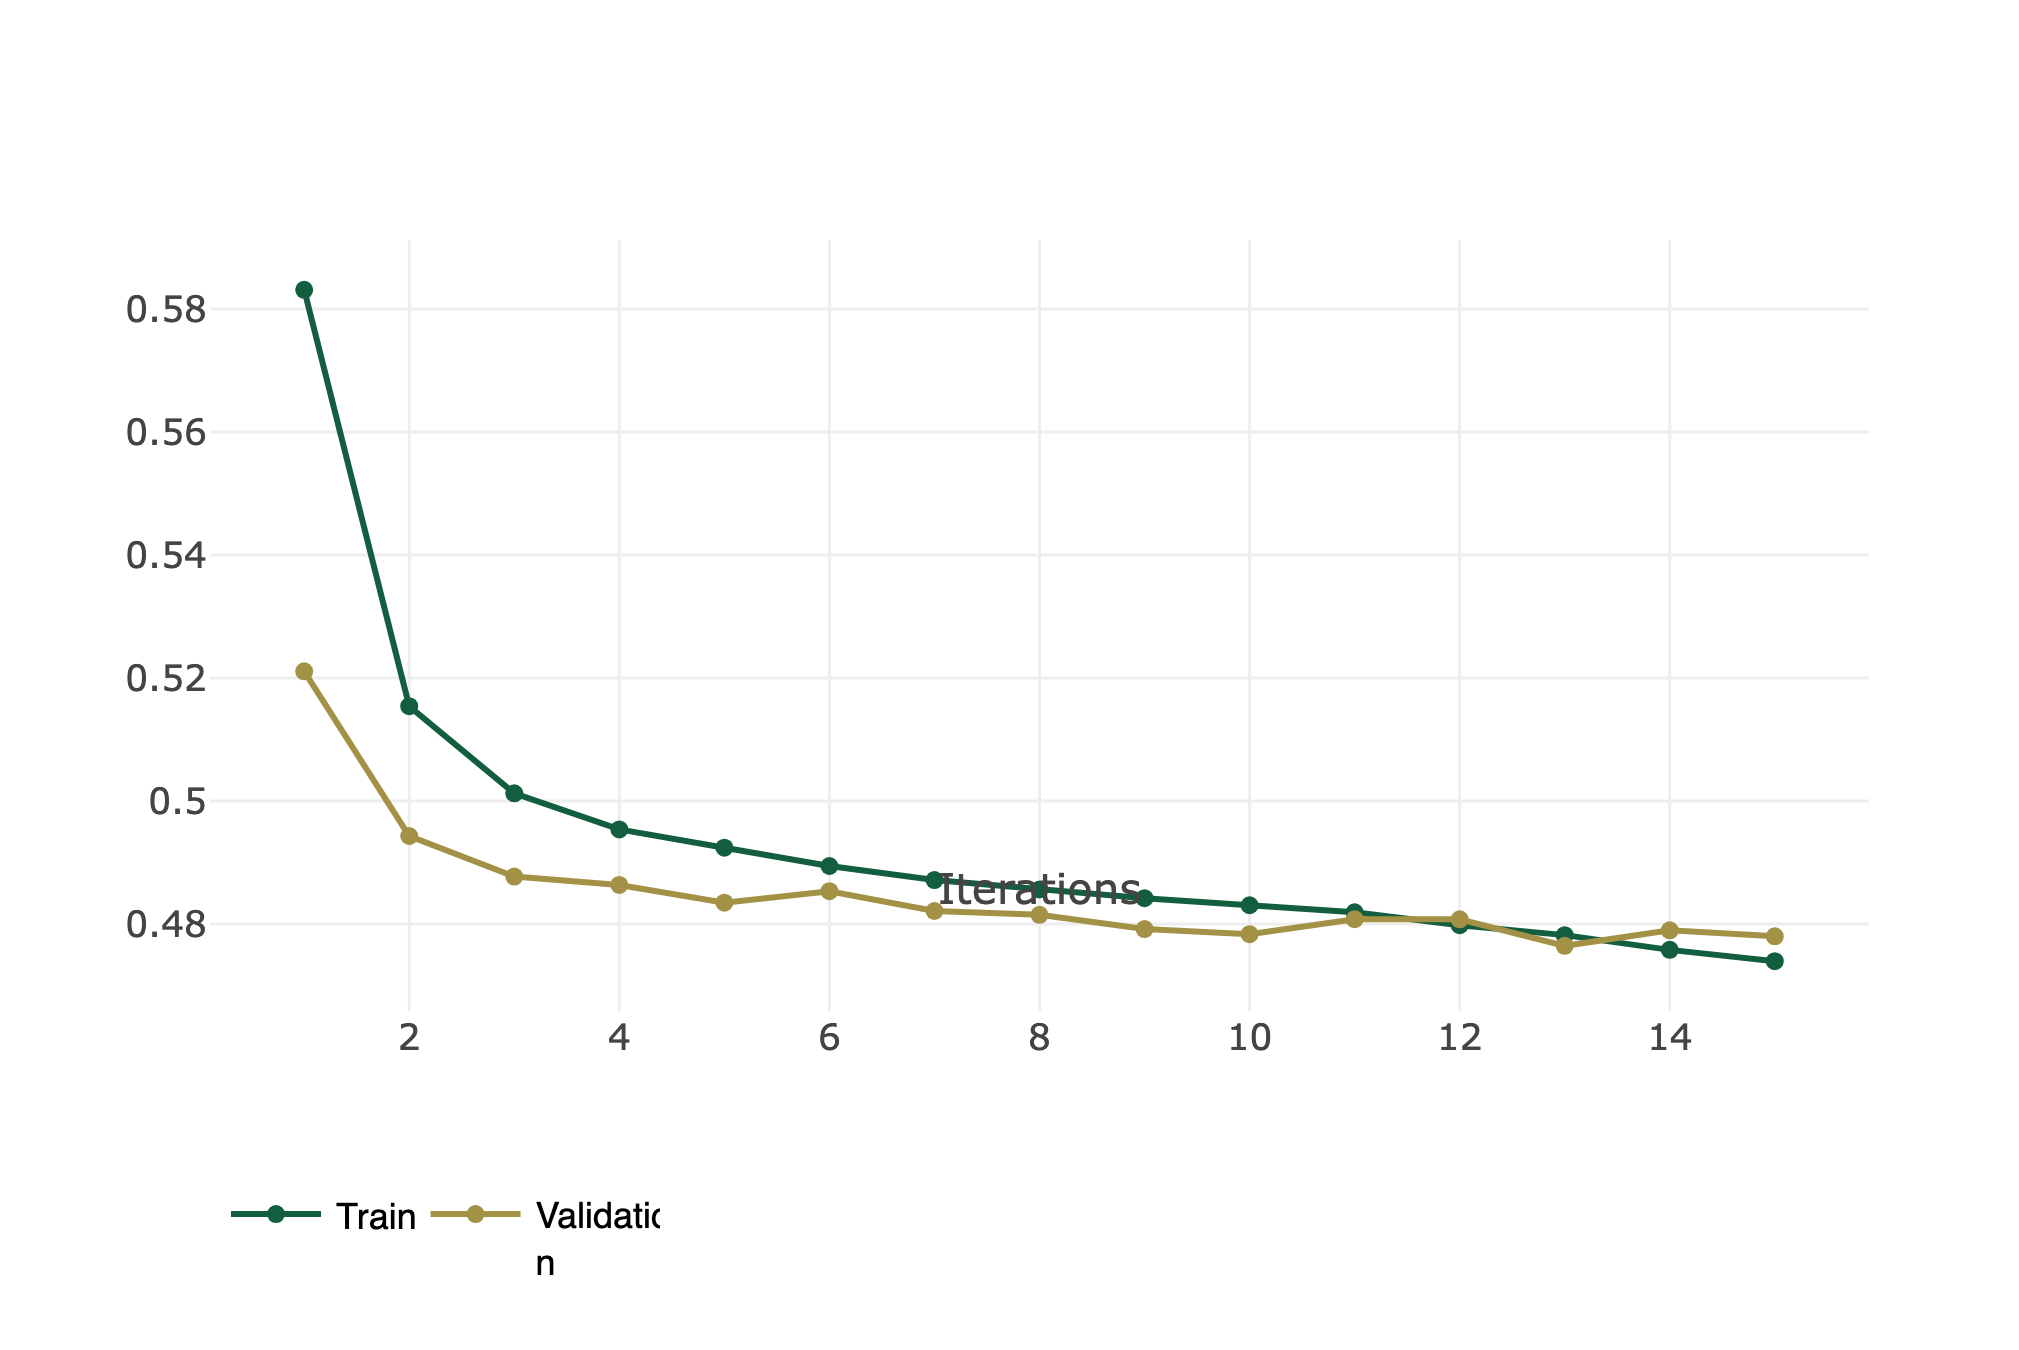

# ROC-AUC Curve
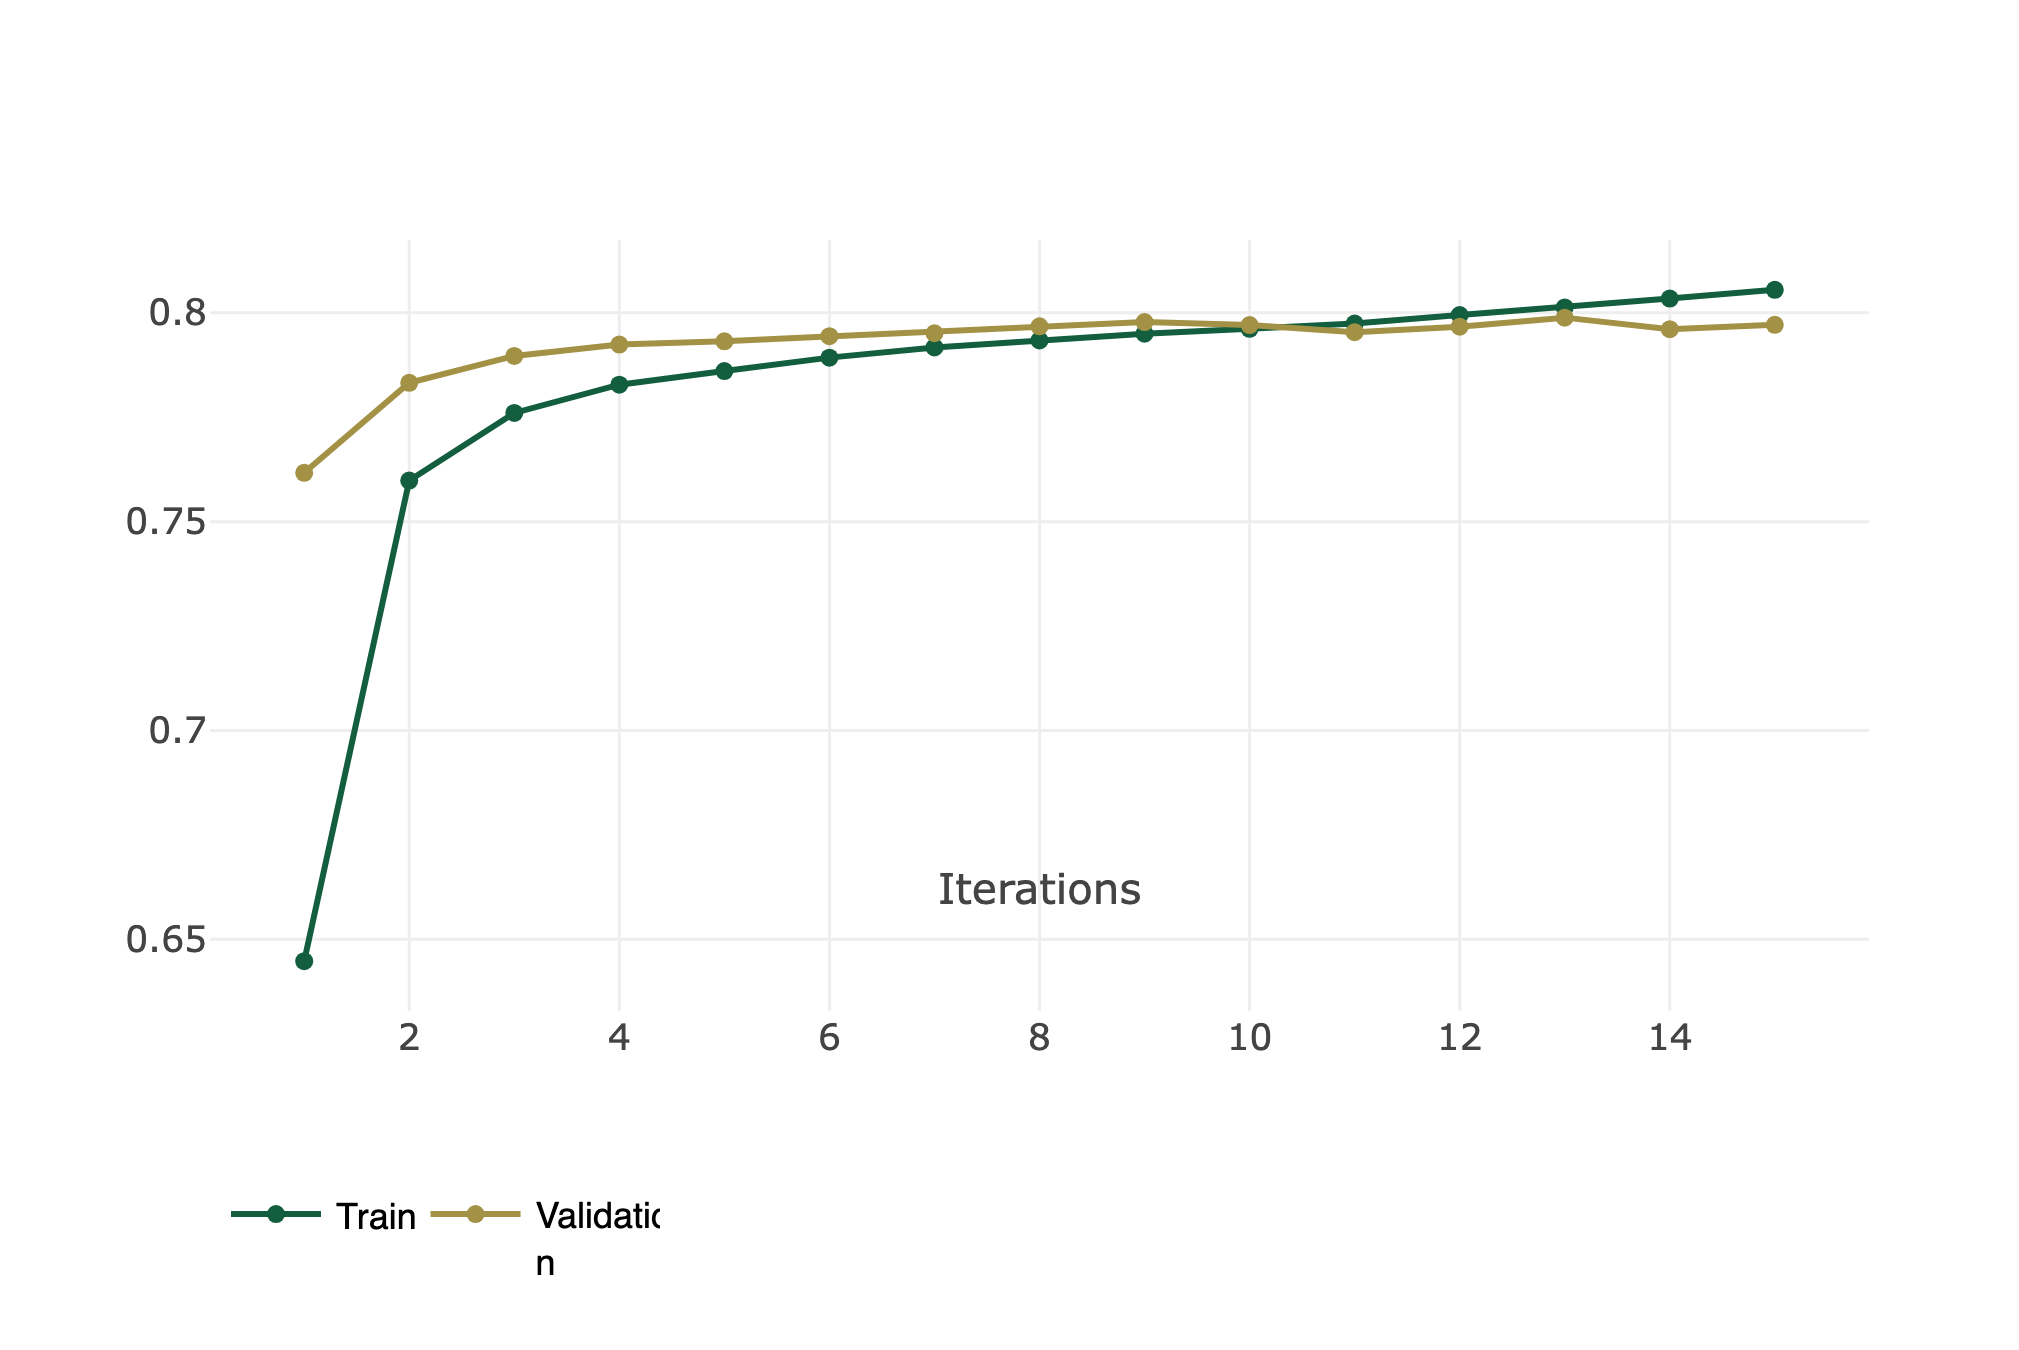